# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Calculate-the-correct-camera-matrix-and-distortion-coefficients" data-toc-modified-id="Calculate-the-correct-camera-matrix-and-distortion-coefficients-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Calculate the correct camera matrix and distortion coefficients</a></div>

In [1]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

# Calculate the correct camera matrix and distortion coefficients

In [10]:
def get_calibration_param(image_url):
    images = glob.glob(image_url)

    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    corner = (9, 6)
    
    for image in images:
        img = mpimg.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, corner, None)

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    print("finish get_calibration_param")
    return objpoints, imgpoints, mtx, dist

objpoints, imgpoints, mtx, dist = get_calibration_param('./camera_cal/calibration*.jpg')
np.savez("./calibration.npz",mtx=mtx, dist=dist)

finish get_calibration_param


In [11]:
def get_undistortion(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

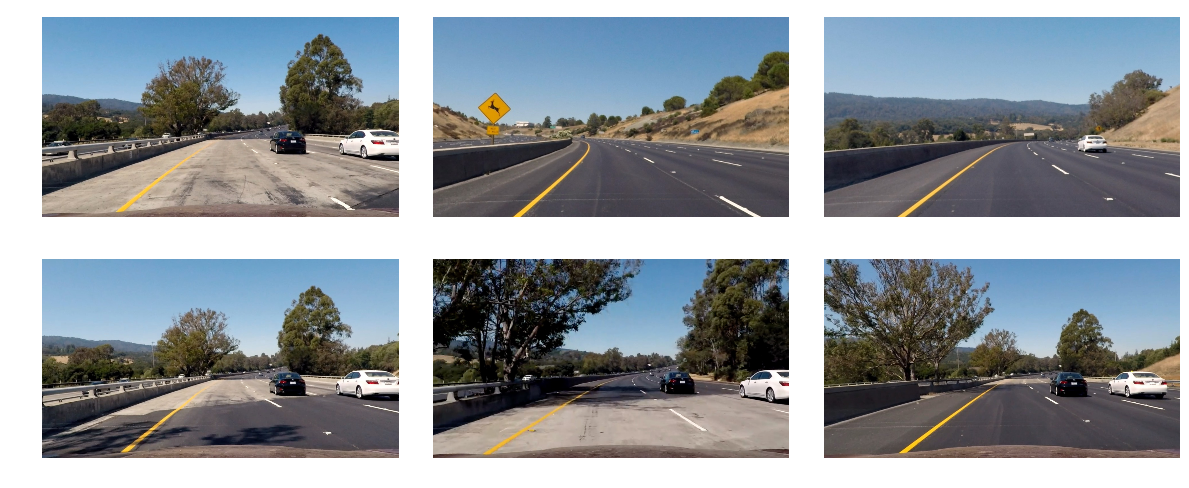

In [14]:
try:
    calibration_param = np.load('./calibration.npz')
except IOError as e:
    print("There is no file like path")
else:
    mtx = calibration_param['mtx']
    dist = calibration_param['dist']
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            undist_img = get_undistortion(image, mtx, dist)
            axes[i, j].imshow(undist_img)
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

In [17]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def dir_threshold(img_ch, sobel_kernel=3, thresh=(0, np.pi/2)):    
    sobelx = cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    with np.errstate(divide='ignore', invalid='ignore'):
        abs_grad_dir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(abs_grad_dir)
        dir_binary[(abs_grad_dir > thresh[0]) & (abs_grad_dir < thresh[1])] = 1

    return dir_binary

def get_converted_color_img(undist, color=cv2.COLOR_RGB2HLS):
    return cv2.cvtColor(undist, color)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline


def get_Binary_From_HLS(undist_img, thres=(110, 255)):
    undist_img = adjust_gamma(undist_img, 0.9)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    return s_binary

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=5, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=7)

    return slope_binary


def histogram(img, xsteps=20, ysteps=40, window_width=10):
    def get_max_index_of_histogram(histogram, left_boundary, right_boundary, window_width=10):
        index_list = []
        side_histogram = histogram[left_boundary : right_boundary]
        for i in range(len(side_histogram) - window_width):
            index_list.append(np.sum(side_histogram[i : i + window_width]))
        index = np.argmax(index_list) + int(window_width / 2) + left_boundary
        return index
    
    xstride = img.shape[0] // xsteps
    ystride = img.shape[1] // ysteps 
    for xstep in range(xsteps):
        histogram = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        boundary = int(img.shape[1] / 2)
        leftindex = get_max_index_of_histogram(histogram, 0, boundary, window_width=window_width)
        rightindex = get_max_index_of_histogram(histogram, boundary, img.shape[1], window_width=window_width)
        
        # mask image
        if histogram[leftindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), : leftindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftindex+ysteps+1 : boundary] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : boundary] = 0
            
        if histogram[rightindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), boundary :rightindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightindex+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), boundary : ] = 0
            
    left_fit_line = cal_poly(img, 0, boundary)
    right_fit_line = cal_poly(img, boundary, img.shape[1])
    yvals = np.arange(img.shape[0])
             
    return img, left_fit_line, right_fit_line, yvals

def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    fit_equation = np.polyfit(yvals, xvals, 2)
    yvals = np.arange(img.shape[0])
    fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
    return fit_line


class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

    
class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=5, thres=(20, 255))
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s, h, s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s, h, s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(conversion_img)
        top_down, left_lines, right_lines, yvals = histogram(top_down, xsteps=40, ysteps=3, window_width=10)
        new_image = np.zeros_like(top_down)
        for yv, ll in zip(yvals, left_lines):
            new_image[yv, ll-10:ll+10] = 1
        for yv, rl in zip(yvals, right_lines):
            new_image[yv, rl-10 : rl+10] = 1
        
        new_image = self.perspective_transform.inv_transform(new_image)
        color=[255, 0, 0]
        index = np.where(new_image == 1)
        pt = np.vstack((index[1], index[0]))
        pt = np.transpose(pt)

        cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
        undist_img[new_image==1] = color
        return undist_img

In [19]:
def process_image(image):
#     OFFSET = 105
#     SRC = np.float32([
#     (380, 720),
#     (620, 455),
#     (720, 455),
#     (1200, 720)])
#     a = 50
#     DST = np.float32([
#         (SRC[0][0] - a + OFFSET, SRC[0][1]),
#         (SRC[0][0] - a + OFFSET, 0),
#         (SRC[-1][0] - OFFSET, 0),
#         (SRC[-1][0] - OFFSET, SRC[0][1])])
#     OFFSET = 200 BEST
#     SRC = np.float32([
#         (300, 720),
#         (580, 455),
#         (730, 455),
#         (1100, 720)])
    OFFSET = 140
    SRC = np.float32([
        (300, 720),
        (595, 455),
        (700, 455),
        (1100, 720)])
    
    DST = np.float32([
        (SRC[0][0] - 50 + OFFSET, SRC[0][1]),
        (SRC[0][0] - 50 + OFFSET, 0),
        (SRC[-1][0] - OFFSET, 0),
        (SRC[-1][0] - OFFSET, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        
    ld = LineDetect(SRC, DST, do_calibration=calibration_param)
    finish = ld.process_image(image)   
    return finish

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = './my.mp4'
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

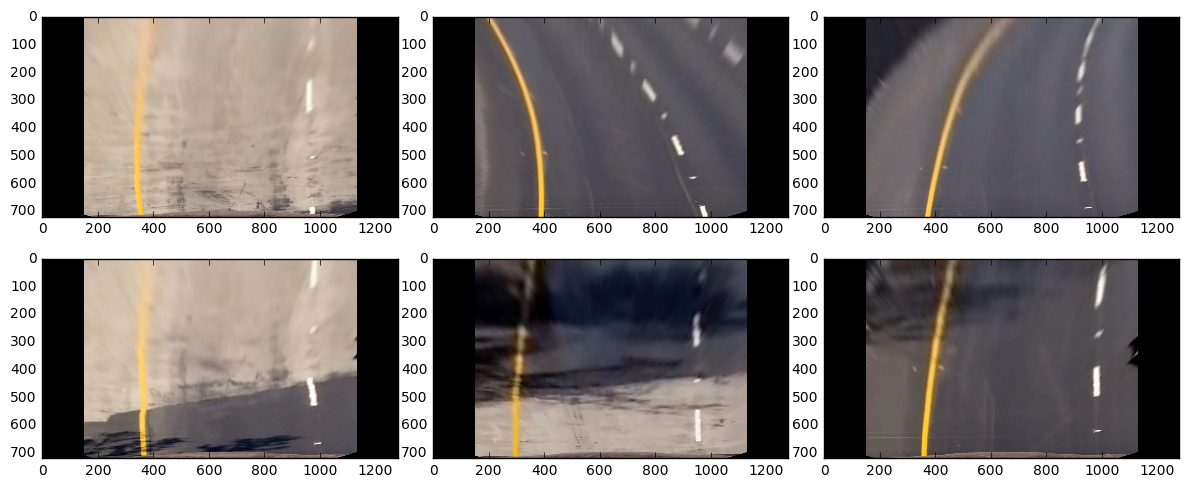

In [53]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline


def get_Binary_From_HLS(undist_img, thres=(110, 255)):
    undist_img = adjust_gamma(undist_img, 0.9)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_converted_color_img(undist, color=cv2.COLOR_RGB2HLS):
    return cv2.cvtColor(undist, color)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=5, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=7)

    return slope_binary

def histogram(img, xsteps=20, ysteps=40, window_width=10):
    def get_max_index_of_histogram(histogram, left_boundary, right_boundary, window_width=10):
        index_list = []
        side_histogram = histogram[left_boundary : right_boundary]
        for i in range(len(side_histogram) - window_width):
            index_list.append(np.sum(side_histogram[i : i + window_width]))
        index = np.argmax(index_list) + int(window_width / 2) + left_boundary
        return index
    
    xstride = img.shape[0] // xsteps
    ystride = img.shape[1] // ysteps 
    for xstep in range(xsteps):
        histogram = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        boundary = int(img.shape[1] / 2)
        leftindex = get_max_index_of_histogram(histogram, 0, boundary, window_width=window_width)
        rightindex = get_max_index_of_histogram(histogram, boundary, img.shape[1], window_width=window_width)
        
        # mask image
        if histogram[leftindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), : leftindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftindex+ysteps+1 : boundary] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : boundary] = 0
            
        if histogram[rightindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), boundary :rightindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightindex+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), boundary : ] = 0
            
    left_fit_line = cal_poly(img, 0, boundary)
    right_fit_line = cal_poly(img, boundary, img.shape[1])
    yvals = np.arange(img.shape[0])
             
    return img, left_fit_line, right_fit_line, yvals

def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    fit_equation = np.polyfit(yvals, xvals, 2)
    yvals = np.arange(img.shape[0])
    fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
    return fit_line


class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=5, thres=(20, 255))
        white = get_white_line(undist_img)
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s_binary, slope, color_binary, white

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s_binary, slope, conversion_img, white = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(undist_img)
        top_down[:, :150] = 0
        top_down[:, 1130:] = 0
        return undist_img, s_binary, slope, conversion_img, top_down

if __name__ == '__main__':
    OFFSET = 120
    SRC = np.float32([
        (200, 720),
        (585, 460),
        (725, 460),
        (1140, 720)])
    
#     DST = np.float32([
#         (SRC[0][0] - 50 + OFFSET, SRC[0][1]),
#         (SRC[0][0] - 50 + OFFSET, 0),
#         (SRC[-1][0] - OFFSET, 0),
#         (SRC[-1][0] - OFFSET, SRC[0][1])])
    DST = np.float32([
        (320, SRC[0][1]),
        (320, 0),
        (960, 0),
        (960, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        

    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            ld = LineDetect(SRC, DST, do_calibration=calibration_param)
            undist, color, slope, conversion_img, top_down = ld.process_image(image)
            axes[i, j].imshow(top_down, cmap='gray')
            
    fig.tight_layout()
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

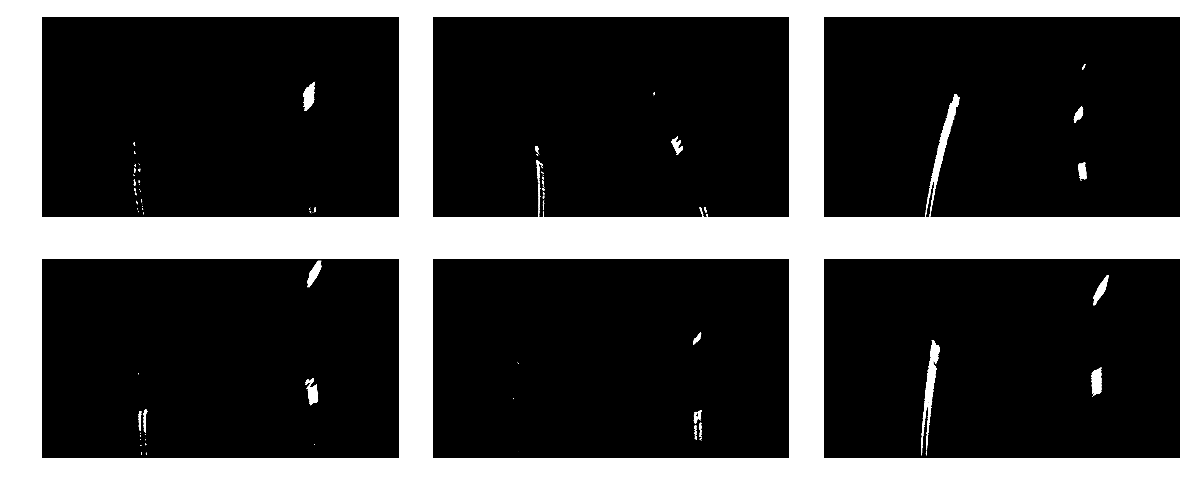

In [102]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline


def get_Binary_From_HLS(undist_img, thres=(110, 255)):
    undist_img = adjust_gamma(undist_img, 0.9)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_converted_color_img(undist, color=cv2.COLOR_RGB2HLS):
    return cv2.cvtColor(undist, color)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=5, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=7)

    return slope_binary



def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    fit_equation = np.polyfit(yvals, xvals, 2)
    yvals = np.arange(img.shape[0])
    fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
    return fit_line


class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

    
class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=5, thres=(20, 255))
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(slope)
        top_down[:, :100] = 0
        top_down[:, 1150:] = 0
        return top_down
#         top_down, left_lines, right_lines, yvals = histogram(top_down, xsteps=20, ysteps=5, window_width=15)
#         new_image = np.zeros_like(top_down)
#         for yv, ll in zip(yvals, left_lines):
#             new_image[yv, ll-10:ll+10] = 1
#         for yv, rl in zip(yvals, right_lines):
#             new_image[yv, rl-10 : rl+10] = 1
        
#         new_image = self.perspective_transform.inv_transform(new_image)
#         color=[255, 0, 0]
#         index = np.where(new_image == 1)
#         pt = np.vstack((index[1], index[0]))
#         pt = np.transpose(pt)

#         cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
#         undist_img[new_image==1] = color
#         return undist_img
    

if __name__ == '__main__':
    SRC = np.float32([
        (200, 720),
        (585, 460),
        (725, 460),
        (1140, 720)])
    
    DST = np.float32([
        (320, SRC[0][1]),
        (320, 0),
        (960, 0),
        (960, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        

    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            ld = LineDetect(SRC, DST, do_calibration=calibration_param)
            top_down = ld.process_image(image)   
            axes[i, j].imshow(top_down, cmap='gray')
            
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

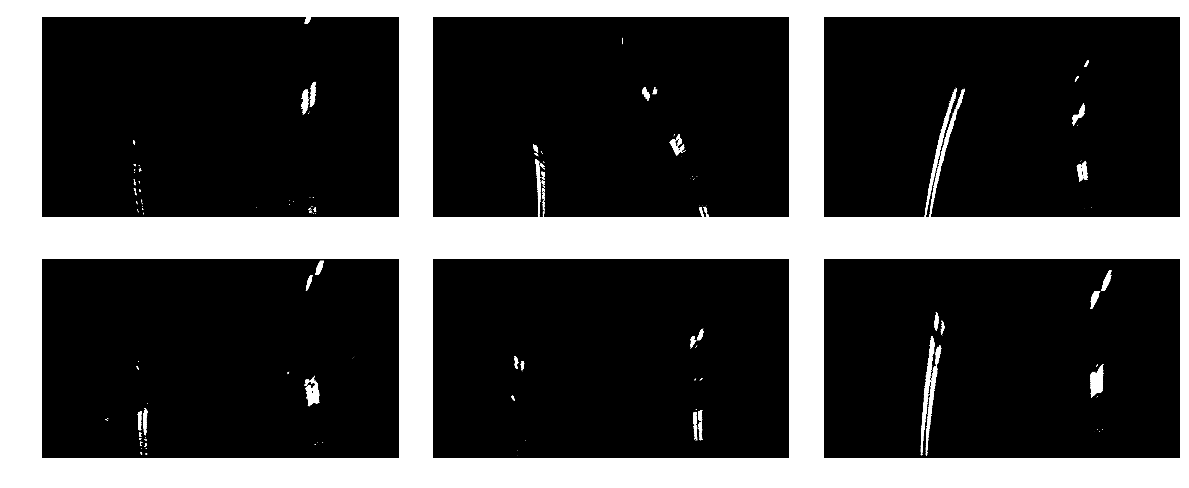

In [128]:
def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.3)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=sobel_kernel, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=3)

    return slope_binary

class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=13, thres=(30, 255))
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(slope)
        top_down[:, :130] = 0
        top_down[:, 1150:] = 0
        top_down[:, 600: 680] = 0
        return top_down


if __name__ == '__main__':
    SRC = np.float32([
        (200, 720),
        (585, 460),
        (725, 460),
        (1140, 720)])
    
    DST = np.float32([
        (320, SRC[0][1]),
        (320, 0),
        (960, 0),
        (960, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")

    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            ld = LineDetect(SRC, DST, do_calibration=calibration_param)
            top_down = ld.process_image(image)   
            axes[i, j].imshow(top_down, cmap='gray')
            
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)